# Investigate how different nearest neighbor map from ungridded to the model grid

In [2]:
import pyresample
import numpy as np
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')

import ecco_v4_py as ecco
import ecco_access as ea

### Load any ECCO dataset that comes with the grid
This is overkill, just want to grab the model grid's lon and lat fields

In [3]:
access_mode = 's3_open_fsspec'


# ECCO_dir specifies parent directory of all ECCOv4r4 downloads
# ECCO_dir = None downloads to default path ~/Downloads/ECCO_V4r4_PODAAC/
ECCO_dir = join('/efs_ecco','ECCO_V4r4_PODAAC')

# for access_mode = 's3_open_fsspec', need to specify the root directory 
# containing the jsons
jsons_root_dir = join('/efs_ecco','mzz-jsons')


ShortNames_list = ["ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]

# retrieve files
StartDate = '2010-01'
EndDate = '2010-12'
ds = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                 StartDate=StartDate,EndDate=EndDate,\
                                 mode=access_mode,\
                                 download_root_dir=ECCO_dir,\
                                 max_avail_frac=0.5,\
                                 jsons_root_dir=jsons_root_dir)

### Plot model longitude and latitude (XC and YC, respectively)

In [ ]:
_, XC_wm = ecco.plot_tiles(ds.XC, layout='latlon', rotate_to_latlon=True, show_tile_labels=False)
plt.close()
_, YC_wm = ecco.plot_tiles(ds.YC, layout='latlon', rotate_to_latlon=True, show_tile_labels=False)
plt.close()
# XC_wm.shape

### One example of a nearest neighbors function that will map us from ungridded to gridded lat/lon pairs

In [83]:
from scipy.spatial import KDTree

def latlon_ungridded_to_gridded(ds, ungridded_lat, ungridded_lon):

    # get gridded/llc coordinates
    grid_shape = ds.XC.shape

    xc = ds.XC.values
    yc = ds.YC.values
    
    gridded_coords = np.c_[yc.ravel(), xc.ravel()]
    ungridded_coords = np.c_[ungridded_lat, ungridded_lon]

    kd_tree = KDTree(gridded_coords)
    distance, nearest_grid_idx = kd_tree.query(ungridded_coords, k=1)

    assert((nearest_grid_idx>np.prod(grid_shape)).sum()==0)

    gridded_lat = yc.ravel()[nearest_grid_idx]
    gridded_lon = xc.ravel()[nearest_grid_idx]
    return gridded_lat, gridded_lon

### Generate random observation points, plot ungridded/gridded

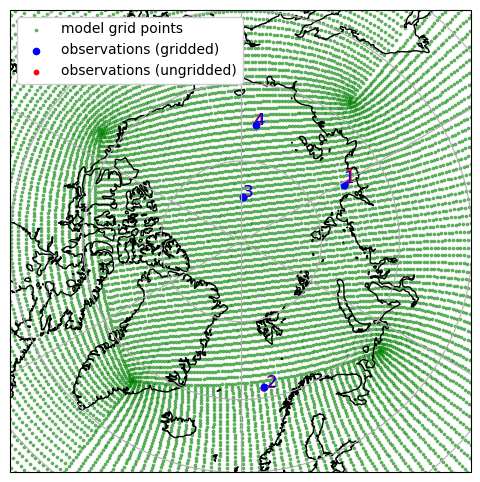

In [117]:
# get ECCO grid
grid_lon, grid_lat = (ds.XC, ds.YC) # each are size (13, 90, 90)
nskip = 2 # easier to see plot with fewer points
grid_lon_flat = grid_lon.values.flatten()
grid_lat_flat = grid_lat.values.flatten()
grid_lon_flat, grid_lat_flat = grid_lon_flat[::nskip], grid_lat_flat[::nskip]

# generate nobs random observations
def generate_random_points(nobs, lon_range=(-180, 180), lat_range=(60, 90)):
    lons = np.random.uniform(low=lon_range[0], high=lon_range[1], size=nobs)
    lats = np.random.uniform(low=lat_range[0], high=lat_range[1], size=nobs)
    return lons, lats

nobs = 4
ungridded_lons, ungridded_lats = generate_random_points(nobs)
gridded_lats, gridded_lons = latlon_ungridded_to_gridded(ds, ungridded_lats, ungridded_lons)


# plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Orthographic(central_longitude=0, central_latitude=90)})

ax.scatter(grid_lon_flat, grid_lat_flat, color='green', s=3, transform=ccrs.PlateCarree(), alpha=.5, label='model grid points')
ax.scatter(gridded_lons, gridded_lats, color='blue', s=20, transform=ccrs.PlateCarree(), label='observations (gridded)')
ax.scatter(ungridded_lons, ungridded_lats, color='r', s=10, transform=ccrs.PlateCarree(), label='observations (ungridded)')

for i, (lon, lat) in enumerate(zip(ungridded_lons, ungridded_lats), start=1):
    ax.scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree())
    ax.text(lon + 1, lat, str(i), color='red', fontsize=12, transform=ccrs.PlateCarree())

# Plot resampled points in blue with labels
for i, (lon, lat) in enumerate(zip(gridded_lons, gridded_lats), start=1):
    ax.scatter(lon, lat, color='blue', s=20, transform=ccrs.PlateCarree())
    ax.text(lon + 1, lat, str(i), color='blue', fontsize=12, transform=ccrs.PlateCarree())


ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.legend(facecolor='white', framealpha=1)